<a href="https://colab.research.google.com/github/omidkhalafbeigi/gan_mnist/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
import numpy as np
from matplotlib import pyplot as plt
import random
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

We can use "Tanh" too as activation function for discriminator last layer, but by personal experience, it's better to use sigmoid.
When I used sigmoid, generated hand-written numbers in the end, were so better... 

In [ ]:
def create_generator():
  model = keras.Sequential()
  model.add(keras.layers.Dense(units=128, activation=keras.activations.LeakyReLU(alpha=0.01), input_shape=(100,)))
  model.add(keras.layers.Dense(units=784, activation='sigmoid'))  

  return model

In [ ]:
def create_discriminator():
  model = keras.Sequential()
  model.add(keras.layers.Dense(units=128, activation=keras.layers.LeakyReLU(alpha=0.01), name='discriminator_layer1', input_shape=(784,)))
  model.add(keras.layers.Dense(units=1, activation='sigmoid'))
  
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
  return model

In [ ]:
discriminator = create_discriminator()
generator = create_generator()

Attention: It's better to use 'add' function to combine two networks (Instead of Model class).

At the end of this project, I tried to combine two networks by this class, but training failed!

I have no idea why this happened...

In [ ]:
discriminator.trainable = False

gan = keras.Sequential()

gan.add(generator)
gan.add(discriminator)

gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Combination Train+Test dataset for more accuracy! (60,000 + 10,000=70,000 rows)

In [ ]:
train = tf.keras.datasets.mnist.load_data()[0][0]
test = tf.keras.datasets.mnist.load_data()[1][0]

In [ ]:
X = np.vstack((train, test))
X = np.reshape(X, newshape=(X.shape[0], X.shape[1] * X.shape[1]))
scaler = MinMaxScaler(feature_range=(0, 1))

X = scaler.fit_transform(X)

In [ ]:
real_input_discriminator = shuffle(X[:, :])
real_label_discriminator = np.ones(shape=real_input_discriminator.shape[0]).reshape(-1, 1)

Attention: When we start training both networks ('D' and 'G'), in the process of training, 'G' loss value should be between 0.1 and 1 and 'D' loss value should be between 0.4 and 2 or higher!

If at the beginning of training, you faced with loss value 0 for both 'D' and 'G' (or after afew iterations), your training is failed and you should review networks architecture and hyperparameters.

I tried to use 'Label-Smoothing' method to get comfortable for generator network!

When we use this method, fooling discriminator by generator is more easier. In fact, we consider some penalties for generator.

"value 0.9 as label 1 and value 0.1 as label 0"

Epoch: 0
G Loss: 1.0676477989215991 - D Loss: 0.3347084342123388


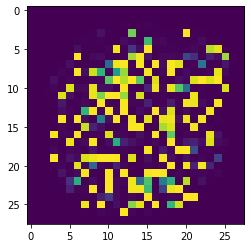

-------------------
Epoch: 10
G Loss: 1.009208606221737 - D Loss: 0.35314306419192654


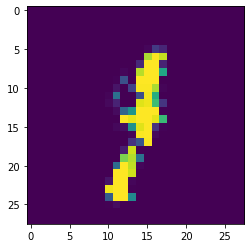

-------------------
Epoch: 20
G Loss: 0.8503015594604688 - D Loss: 0.4284458846945466


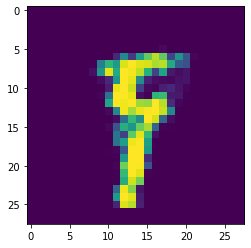

-------------------
Epoch: 30
G Loss: 0.8113064420092236 - D Loss: 0.45403174687272463


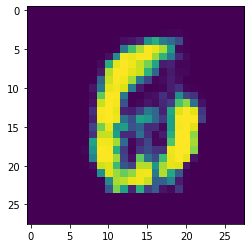

-------------------
Epoch: 40
G Loss: 0.7946504840047368 - D Loss: 0.46224035911616823


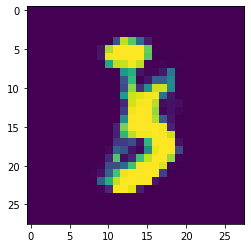

-------------------
Epoch: 50
G Loss: 0.7850403542592849 - D Loss: 0.4658202886499546


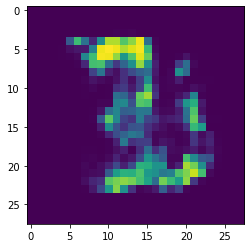

-------------------
Epoch: 60
G Loss: 0.7780742071814589 - D Loss: 0.4672964250812164


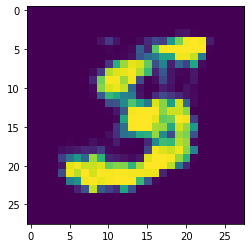

-------------------
Epoch: 70
G Loss: 0.7790683394386655 - D Loss: 0.46630266195524744


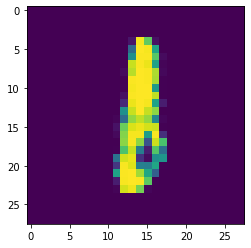

-------------------
Epoch: 80
G Loss: 0.7759954088118487 - D Loss: 0.467678708645887


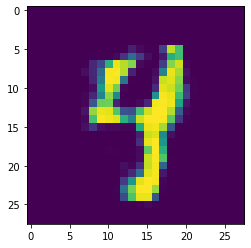

-------------------
Epoch: 90
G Loss: 0.7703298066780244 - D Loss: 0.4687838359548277


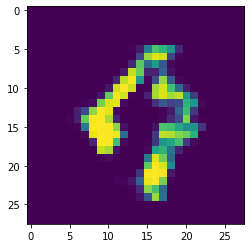

-------------------
Epoch: 100
G Loss: 0.7717384792291201 - D Loss: 0.46975154565040006


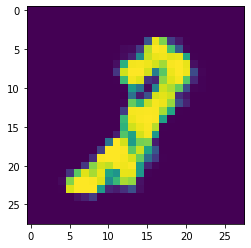

-------------------
Epoch: 110
G Loss: 0.7696736862480422 - D Loss: 0.4703985615418507


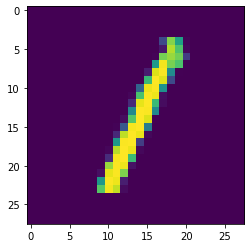

-------------------
Epoch: 120
G Loss: 0.7728768873564053 - D Loss: 0.46941223991113706


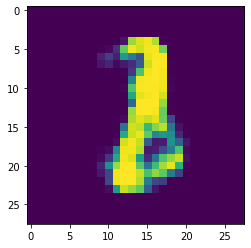

-------------------
Epoch: 130
G Loss: 0.7742651089425489 - D Loss: 0.46823195710014076


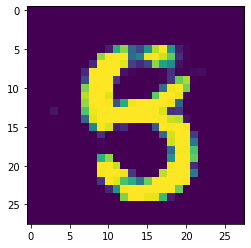

-------------------
Epoch: 140
G Loss: 0.7753538098964062 - D Loss: 0.4671678506683954


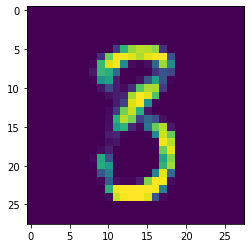

-------------------
Epoch: 150
G Loss: 0.775344037256398 - D Loss: 0.4665721308399033


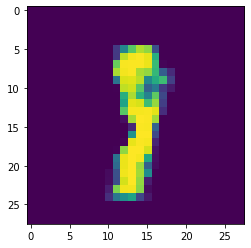

-------------------
Epoch: 160
G Loss: 0.7762118688323996 - D Loss: 0.4658052376938827


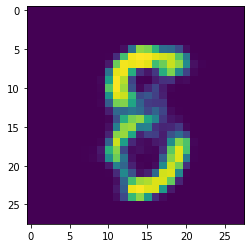

-------------------
Epoch: 170
G Loss: 0.7754906415611833 - D Loss: 0.46538669430401736


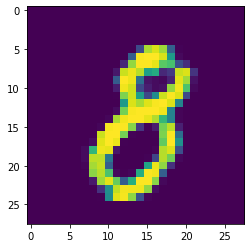

-------------------
Epoch: 180
G Loss: 0.7765828843081827 - D Loss: 0.4647414105115356


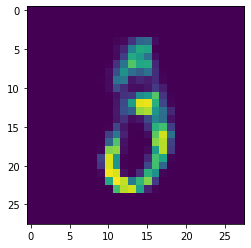

-------------------
Epoch: 190
G Loss: 0.7752524580601807 - D Loss: 0.46473648624269515


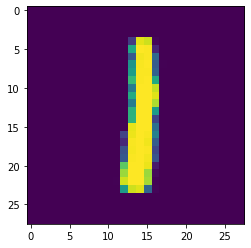

-------------------


In [ ]:
epochs = 200
batch_size = 128

d_loss = list()
g_loss = list()

d_loss_i = list()
g_loss_i = list()

for epoch in range(epochs):
    for i in range(batch_size, X.shape[0], batch_size):
        generator.trainable = False
        discriminator.trainable = True

        d_loss_1 = discriminator.train_on_batch(x=real_input_discriminator[i - batch_size:i], y=np.full((batch_size,), fill_value=0.9).reshape(-1, 1))
        d_loss_2 = discriminator.train_on_batch(x=generator.predict(np.random.normal(size=(batch_size, 100))), y=np.full((batch_size,), fill_value=0.1).reshape(-1, 1))

        d_loss.append((d_loss_1[0] + d_loss_2[0]) / 2)
        d_loss_i.append((d_loss_1[0] + d_loss_2[0]) / 2)

        generator.trainable = True
        discriminator.trainable = False

        g_loss_value = gan.train_on_batch(x=np.random.normal(size=(batch_size, 100)), y=np.full((batch_size,), fill_value=0.9))

        g_loss.append(g_loss_value)
        g_loss_i.append(g_loss_value)

    if epoch % 10 == 0:
      print(f'Epoch: {epoch}')
      print(f'G Loss: {np.average(g_loss_i)} - D Loss: {np.average(d_loss_i)}')

      g_loss_i.clear()
      d_loss_i.clear()

      plt.imshow(generator.predict(np.random.normal(size=(1, 100))).reshape(28, 28))
      plt.show()

      print('-------------------')

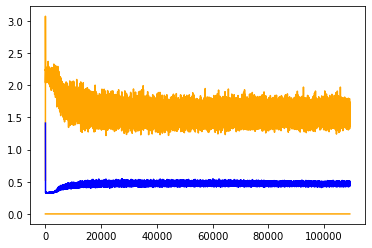

In [ ]:
plt.plot(g_loss, 'orange')
plt.plot(d_loss, 'blue')
plt.show()

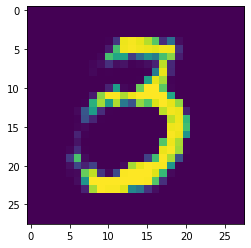

In [ ]:
plt.imshow(generator.predict(np.random.normal(size=(1, 100))).reshape(28, 28))

In [ ]:
discriminator.save('discriminator.h5')
generator.save('generator.h5')
gan.save('gan.h5')